In [1]:
using DrWatson

In [2]:
quickactivate(@__DIR__)

In [3]:
projectdir()

"/var/home/tef30/Projects/mine/Covid19"

In [4]:
# ENV["PYTHON"] = "$(ENV['HOME'])/.local/bin/python"

# using Pkg
# Pkg.build("PyCall")

In [5]:
using Covid19

┌ Info: Precompiling Covid19 [1d6b4b23-2965-494f-a811-b0912eb134ac]
└ @ Base loading.jl:1273


In [6]:
using Turing

In [7]:
using Random
Random.seed!(1);

In [8]:
using Bijectors

In [9]:
begin
    dist = product_distribution(fill(truncated(Normal(3.28, 10), 0, Inf), 14))
    b = bijector(dist)
    x = rand(dist)

    # stupid check to make sure that we have the correct versions of Bijectors.jl used WITHIN Turing.jl
    @assert (invlink(dist, b(x)) ≈ Turing.invlink(dist, b(x))) && (Turing.invlink(dist, b(x)) ≈ x)
end

In [10]:
ImperialReport13.Turing.invlink(dist, b(x))

14-element Array{Float64,1}:
  6.252879845354617 
  7.103959677906078 
  3.1755475536262434
  6.391113384983338 
 26.23087823837311  
  8.57965576166746  
  7.594215264229121 
  9.117082875687785 
 12.912716050381905 
  7.867909550537167 
  7.363958383247523 
  2.775487700663347 
  4.487659649374392 
 11.23948622004616  

In [11]:
ImperialReport13.Turing.link(dist, x)

14-element Array{Float64,1}:
 1.8330421328807285
 1.9606523297033323
 1.1554800753105494
 1.8549084918631922
 3.266937275528449 
 2.1493937916772228
 2.027386808027437 
 2.210149892798127 
 2.5582125661843405
 2.0627924045961143
 1.996597611976199 
 1.0208264797433213
 1.50133132964383  
 2.419433133460507 

In [12]:
b(x)

14-element Array{Float64,1}:
 1.8330421328807285
 1.9606523297033323
 1.1554800753105494
 1.8549084918631922
 3.266937275528449 
 2.1493937916772228
 2.027386808027437 
 2.210149892798127 
 2.5582125661843405
 2.0627924045961143
 1.996597611976199 
 1.0208264797433213
 1.50133132964383  
 2.419433133460507 

In [13]:
ImperialReport13.Turing.logpdf_with_trans(dist, x, true)

-14.764535844208288

In [14]:
logpdf_forward(transformed(dist, b), x)

-14.764535844208293

# Load data

In [15]:
using RData

In [16]:
import DrWatson: datadir

datadir() = projectdir("data", "imperial-report13")
datadir(s...) = projectdir("data", "imperial-report13", s...)

datadir (generic function with 2 methods)

In [17]:
datadir()

"/var/home/tef30/Projects/mine/Covid19/data/imperial-report13"

In [18]:
rdata = load(datadir("processed.rds"));

┌ Warning: Unsupported AltRep SEXP
└ @ RData /var/home/tef30/.julia/packages/RData/7cjT6/src/convert.jl:205


In [19]:
# Convert some misparsed fields
rdata["covariate4"] = Matrix(rdata["covariate4"]);

rdata["N2"] = Int(rdata["N2"]);
rdata["N0"] = Int(rdata["N0"]);

rdata["EpidemicStart"] = Int.(rdata["EpidemicStart"]);

rdata["cases"] = Int.(rdata["cases"]);
rdata["deaths"] = Int.(rdata["deaths"]);

rdata["x"] = []

0-element Array{Any,1}

## Make data a bit more convenient to work with

In [20]:
countries = (
  "Denmark",
  "Italy",
  "Germany",
  "Spain",
  "United_Kingdom",
  "France",
  "Norway",
  "Belgium",
  "Austria", 
  "Sweden",
  "Switzerland",
  "Greece",
  "Portugal",
  "Netherlands"
)
num_countries = length(countries)

# TODO: not sure if either of the below is the correct ordering of the names!
# names_covariates = (
#     "Schools + Universities",
#     "Self-isolating if ill",
#     "Public events",
#     "Lockdown",
#     "Social distancing encouraged"
# )
names_covariates = ("schools_universities", "self_isolating_if_ill", "public_events", "any", "lockdown", "social_distancing_encouraged")

function rename!(d, names::Pair...)
    # check that keys are not yet present before updating `d`
    for k_new in values.(names)
        @assert k_new ∉ keys(d) "$(k_new) already in dictionary"
    end
    
    for (k_old, k_new) in names
        d[k_new] = pop!(d, k_old)
    end
    return d
end


rename! (generic function with 1 method)

In [21]:
# `rdata` is a `DictOfVector` so we convert to a simple `Dict` for simplicity
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

# Rename some columns
rename!(
    d,
    "f" => "π", "SI" => "serial_intervals", "pop" => "population",
    "M" => "num_countries", "N0" => "num_impute", "N" => "num_obs_countries",
    "N2" => "num_total_days", "EpidemicStart" => "epidemic_start"
)

# Add some type-information to arrays and replace `-1` with `missing` (as `-1` is supposed to represent, well, missing data)
d["deaths"] = Int.(d["deaths"])
d["deaths"] = replace(d["deaths"], -1 => missing)
d["deaths"] = collect(eachcol(d["deaths"])) # convert into Array of arrays instead of matrix

d["cases"] = Int.(d["cases"])
d["cases"] = replace(d["cases"], -1 => missing)
d["cases"] = collect(eachcol(d["cases"])) # convert into Array of arrays instead of matrix

d["num_total_days"] = Int(d["num_total_days"])
d["num_impute"] = Int(d["num_impute"])
d["num_obs_countries"] = Int.(d["num_obs_countries"])
d["epidemic_start"] = Int.(d["epidemic_start"])
d["population"] = Int.(d["population"])

d["π"] = collect(eachcol(d["π"])) # convert into Array of arrays instead of matrix

# Convert to `Matrix` if some are `DataFrame`
covariates = [Matrix(d["covariate$(i)"]) for i = 1:6]
# Array of matrices, with each element in array corresponding to (time, features)-matrix for a country
covariates = [hcat([covariates[i][:, m] for i = 1:6]...) for m = 1:d["num_countries"]]

data = (; (k => d[String(k)] for k in [:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :epidemic_start, :population, :serial_intervals])...)
data = merge(data, (covariates = covariates, ));

In [22]:
data.num_countries

14

# Trying out the model

In [23]:
m = ImperialReport13.model_v2(
    data.num_countries,
    data.num_impute,
    data.num_obs_countries,
    data.num_total_days,
    data.cases,
    data.deaths,
    data.π,
    data.covariates,
    data.epidemic_start,
    data.population,
    data.serial_intervals
);

In [24]:
chain_prior = sample(m, Turing.Inference.PriorSampler(), 10_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:42


In [25]:
chain_prior

Object of type Chains, with data of type 10000×52×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
internals         = lp
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ₀[1], μ₀[2], μ₀[3], μ₀[4], μ₀[5], μ₀[6], μ₀[7], μ₀[8], μ₀[9], μ₀[10], μ₀[11], μ₀[12], μ₀[13], μ₀[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters     mean      std  naive_se    mcse         ess   r_hat
  ─────────────  ───────  ───────  ────────  ──────  ──────────  ──────
   ifr_noise[1]   0.9977   0.0998    0.0010  0.0010  10343.8058  1.0001
   ifr_noise[2]   0.9992   0.0995    0.0010  0.0010

In [26]:
?NUTS

search: NUTS ANUTS DynamicNUTS ncodeunits num_countries InteractiveUtils



```
NUTS(n_adapts::Int, δ::Float64; max_depth::Int=5, Δ_max::Float64=1000.0, ϵ::Float64=0.0)
```

No-U-Turn Sampler (NUTS) sampler.

Usage:

```julia
NUTS()            # Use default NUTS configuration. 
NUTS(1000, 0.65)  # Use 1000 adaption steps, and target accept ratio 0.65.
```

Arguments:

  * `n_adapts::Int` : The number of samples to use with adaptation.
  * `δ::Float64` : Target acceptance rate for dual averaging.
  * `max_depth::Float64` : Maximum doubling tree depth.
  * `Δ_max::Float64` : Maximum divergence during doubling tree.
  * `ϵ::Float64` : Inital step size; 0 means automatically searching using a heuristic procedure.


In [27]:
params = (
    warmup = 100,
    steps = 200,
    model = "imperial-report13-v2-fixed"
)

(warmup = 100, steps = 200, model = "imperial-report13-v2-fixed")

In [28]:
# chain = read(savename("chains", params, "jls"), Chains);

In [78]:
using ForwardDiff

function ImperialReport13.NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ
    
    if !(zero(p) < p ≤ one(p))
        @info ForwardDiff.value(μ) ForwardDiff.value(ϕ) ForwardDiff.value(p) ForwardDiff.value(r)
    end

    return NegativeBinomial(r, p)
end

In [79]:
chain = sample(m, NUTS(params.warmup, 0.95; max_depth=10), params.steps + params.warmup);
write(savename("chains", params, "jls"), chain)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /var/home/tef30/.julia/packages/Turing/udhWN/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 2:05:30


In [80]:
chain

Object of type Chains, with data of type 200×63×1 Array{Float64,3}

Iterations        = 1:200
Thinning interval = 1
Chains            = 1
Samples per chain = 200
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ₀[1], μ₀[2], μ₀[3], μ₀[4], μ₀[5], μ₀[6], μ₀[7], μ₀[8], μ₀[9], μ₀[10], μ₀[11], μ₀[12], μ₀[13], μ₀[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters      mean      std  naive_se     mcse       ess   r_hat
  ─────────────  ───

In [81]:
mean(chain)

Mean
     parameters      mean
  ─────────────  ────────
   ifr_noise[1]    1.0007
   ifr_noise[2]    0.9871
   ifr_noise[3]    0.9879
   ifr_noise[4]    1.0013
   ifr_noise[5]    0.9840
   ifr_noise[6]    0.9980
   ifr_noise[7]    1.0038
   ifr_noise[8]    0.9960
   ifr_noise[9]    1.0123
  ifr_noise[10]    0.9981
  ifr_noise[11]    1.0080
  ifr_noise[12]    1.0066
  ifr_noise[13]    1.0086
  ifr_noise[14]    1.0120
           y[1]   51.4200
           y[2]   60.2541
           y[3]   20.3950
           y[4]   80.0598
           y[5]   45.9348
           y[6]   12.6238
           y[7]   38.8535
           y[8]   23.8873
           y[9]   75.2601
          y[10]   54.4966
          y[11]   39.2365
          y[12]   86.8912
          y[13]   82.5651
          y[14]  107.7765
      α_hier[1]    0.3040
      α_hier[2]    0.0387
      α_hier[3]    0.0834
      α_hier[4]    0.0275
      α_hier[5]    1.0849
      α_hier[6]    0.0420
              κ    1.0267
          μ₀[1]    3.8751
       

# Predictions 

In [82]:
"""
    generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)

Executes `m` for each of the samples in `c` and returns an array of the values returned by the `m` for each sample.

## Examples
Often you might have additional quantities computed inside the model that you want to inspect, e.g.
```julia
@model demo(x) = begin
    # sample and observe
    θ ~ Prior()
    x ~ Likelihood()

    return interesting_quantity(θ, x)
end

m = demo(data)
chain = sample(m, alg, n)

# To inspect the `interesting_quantity(θ, x)` where `θ` is replaced by samples from the posterior/`chain`:
generated_quantities(m, chain)
```
"""
function generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)
    varinfo = Turing.DynamicPPL.VarInfo(m)

    map(1:length(c)) do i
        Turing.DynamicPPL._setval!(varinfo, c[i])
        m(varinfo)
    end
end


generated_quantities

# Visualization

In [83]:
using Plots, StatsPlots
pyplot()

Plots.PyPlotBackend()

In [84]:
function plot_confidence!(p::Plots.Plot, data; label="", kwargs...)
    intervals = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    qs = [quantile(v, intervals) for v in eachrow(data)]
    llq, lq, mq, uq, uuq = (eachrow(hcat(qs...))..., )
    plot!(mq, ribbon=(mq - llq, uuq - mq), linewidth=0, label="$label (95% quantiles)", kwargs...)
    plot!(mq, ribbon=(mq - lq, uq - mq), linewidth=0, label="$label (50% quantiles)", kwargs...)

    return p
end

plot_confidence(data; kwargs...) = plot_confidence!(plot(), data; kwargs...)

plot_confidence (generic function with 1 method)

In [138]:
function country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
    p1 = bar(replace(data.deaths[country_idx], missing => 0.), label="$(countries[country_idx])")
    title!("Daily deaths")
    vline!([data.epidemic_start[country_idx]], label="epidemic start", linewidth=2)
    vline!([data.num_obs_countries[country_idx]], label="end of observations", linewidth=2)

    p2 = plot_confidence(e_deaths_country; label = "$(countries[country_idx])")
    title!("Daily deaths (pred)")
    bar!(replace(data.deaths[country_idx], missing => 0.), label="$(countries[country_idx]) (observed)", alpha=0.5)

    p3 = plot_confidence(Rₜ_country; label = "$(countries[country_idx])")
    for (c_idx, c_time) in enumerate(findfirst.(==(1), eachcol(data.covariates[country_idx])))
        if c_time !== nothing
            # c_name = names(covariates)[2:end][c_idx]
            c_name = names_covariates[c_idx]
            if !(c_name == "any")
                # Don't add the "any intervention" stuff
                vline!([c_time - 1], label=c_name)
            end
        end
    end
    title!("Rₜ")

    # p3 = bar(replace(data.cases[country_idx], missing => -1.), label="$(countries[country_idx])")
    # title!("Daily cases")

    p4 = plot_confidence(predictions_country; label = "$(countries[country_idx])")
    title!("Daily cases (pred)")
    bar!(replace(data.cases[country_idx], missing => 0.), label="$(countries[country_idx]) (observed)", alpha=0.5)

    vals = cumsum(e_deaths_country; dims = 1)
    p5 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.deaths[country_idx]), label="observed")
    title!("Deaths (pred)")

    vals = cumsum(predictions_country; dims = 1)
    p6 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.cases[country_idx]), label="observed")
    title!("Cases (pred)")

    plot(p1, p3, p2, p4, p5, p6, layout=(6, 1), size=(900, 1200))
end

country_prediction_plot (generic function with 2 methods)

In [ ]:
# Compute the "generated quantities" for the PRIOR
res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

In [ ]:
# Compute the "generated quantities" from the POSTERIOR
res = generated_quantities(m, chain)
prediction_chain = [x[1] for x in res];
expected_deaths_chain = [x[2] for x in res];
Rₜ_chain = [x[3] for x in res];

In [147]:
# HACK: eeehm this could be nicer:)
function country_prior_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    Rₜ_country = hcat([Rₜ_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    predictions_country = hcat([prediction_prior[t][country_idx] for t = 1:length(chain_prior)]...)

    return country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
end

country_prior_prediction_plot (generic function with 1 method)

In [148]:
function country_posterior_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_chain[t][country_idx] for t = 1:length(chain)]...)
    Rₜ_country = hcat([Rₜ_chain[t][country_idx] for t = 1:length(chain)]...)
    predictions_country = hcat([prediction_chain[t][country_idx] for t = 1:length(chain)]...)

    return country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
end

country_posterior_prediction_plot (generic function with 1 method)

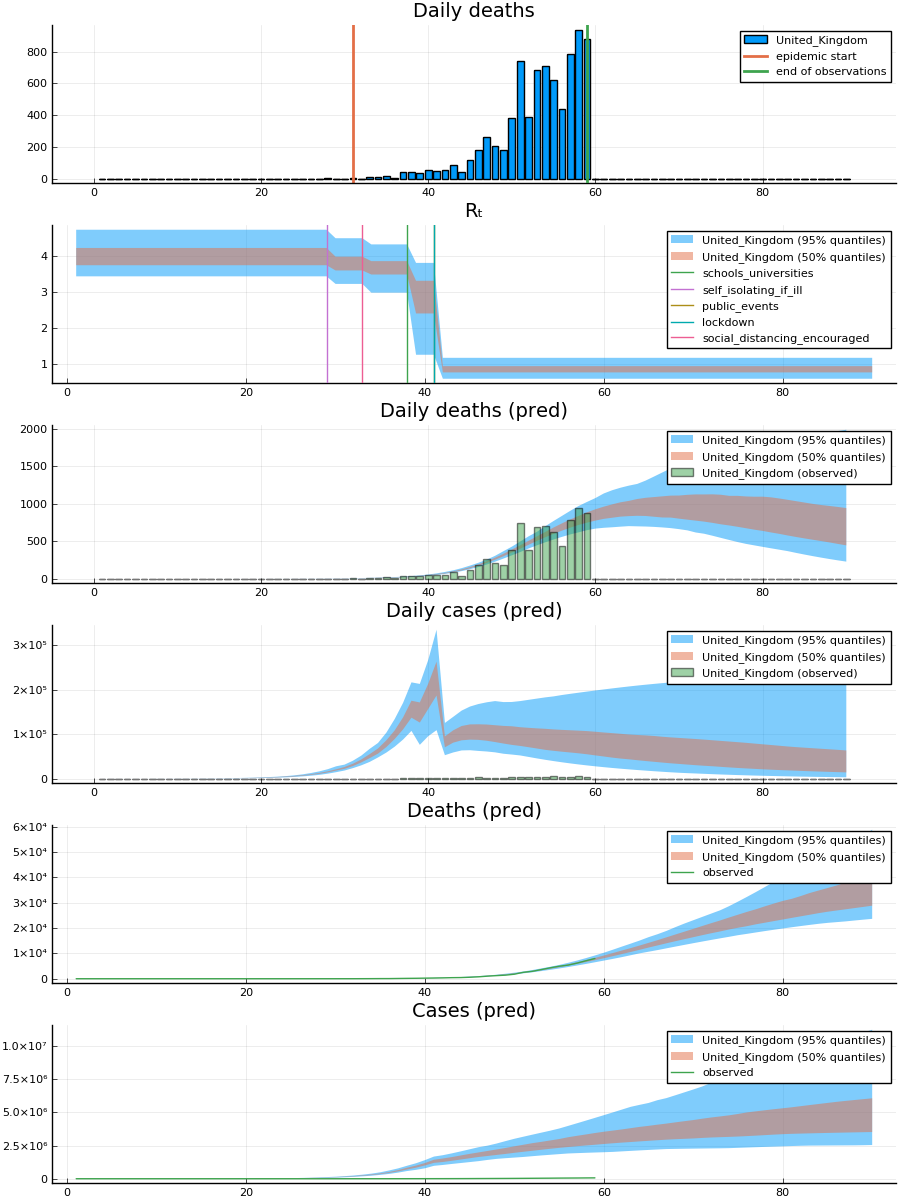

In [149]:
country_posterior_prediction_plot(5)

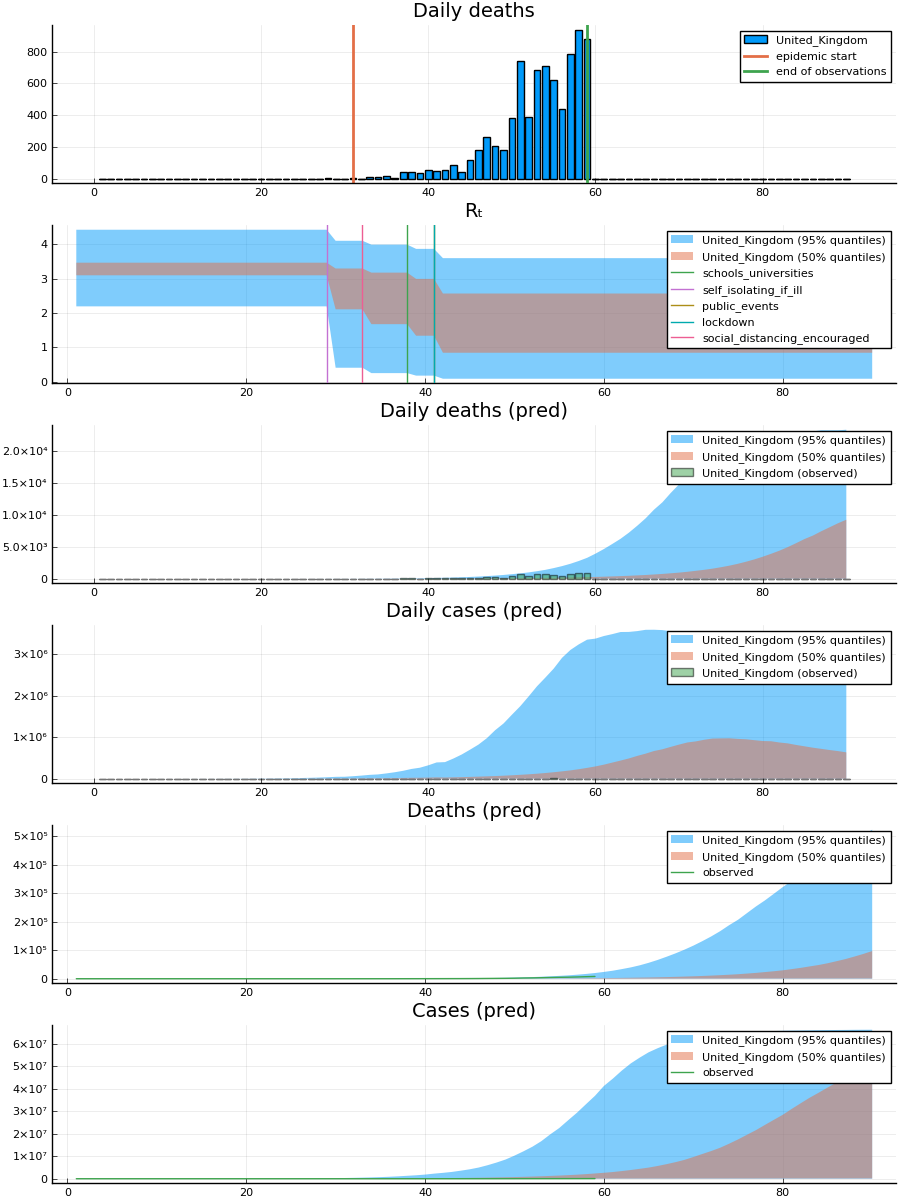

In [150]:
country_prior_prediction_plot(5)

# Comparing with Stan

In [39]:
using PyCall

In [40]:
using PyCall: pyimport
pystan = pyimport("pystan")

PyObject <module 'pystan' from '/var/home/tef30/.local/lib/python3.5/site-packages/pystan/__init__.py'>

In [41]:
using LibGit2

imperialdir() = projectdir("external", "covid19model")
imperialdir(args...) = projectdir("external", "covid19model", args...)

if !ispath(imperialdir())
    mkpath(projectdir("external"))
    LibGit2.clone("https://github.com/ImperialCollegeLondon/covid19model.git", imperialdir())
end

In [42]:
sm = pystan.StanModel(file=imperialdir("stan-models", "base.stan"))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26789167272cf46e6188fa9ce826678d NOW.


PyObject <pystan.model.StanModel object at 0x7fcebdf9fef0>

In [43]:
keys(rdata)

Base.KeySet for a Dict{String,Int64} with 17 entries. Keys:
  "SI"
  "deaths"
  "f"
  "covariate4"
  "covariate5"
  "pop"
  "x"
  "N0"
  "N2"
  "M"
  "N"
  "covariate3"
  "covariate2"
  "EpidemicStart"
  "covariate6"
  "cases"
  "covariate1"

In [44]:
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

Dict{String,Any} with 17 entries:
  "SI"            => [0.0183262, 0.0665923, 0.101914, 0.117717, 0.118386, 0.109…
  "deaths"        => [0 0 … 0 0; 0 0 … 0 0; … ; -1 -1 … -1 -1; -1 -1 … -1 -1]
  "f"             => [1.6332e-8 1.99194e-8 … 1.87614e-8 1.64636e-8; 3.29701e-7 …
  "covariate4"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "covariate5"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "pop"           => Int32[5792203, 60461828, 83783945, 46754783, 67886004, 652…
  "x"             => Any[]
  "N0"            => 6
  "N2"            => 90
  "M"             => 14
  "N"             => Int32[50, 75, 56, 62, 59, 64, 47, 53, 49, 53, 57, 50, 50, …
  "covariate3"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "covariate2"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "EpidemicStart" => [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
  "covariate6"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 

In [45]:
fit_stan(n_iters=2_000) = sm.sampling(
    data=d, iter=n_iters, chains=1, warmup=100, algorithm="NUTS", 
    control=Dict(
        "adapt_delta" => 0.95,
        "max_treedepth" => 10
    )
)
f = fit_stan(300)


Gradient evaluation took 0.011403 seconds
1000 transitions using 10 leapfrog steps per transition would take 114.03 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 15
           adapt_window = 75
           term_buffer = 10

Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 101 / 300 [ 33%]  (Sampling)
Iteration: 130 / 300 [ 43%]  (Sampling)
Iteration: 160 / 300 [ 53%]  (Sampling)
Iteration: 190 / 300 [ 63%]  (Sampling)
Iteration: 220 / 300 [ 73%]  (Sampling)
Iteration: 250 / 300 [ 83%]  (Sampling)
Iteration: 280 / 300 [ 93%]  (Sampling)
Iteration: 300 / 300 [100%]  (Sampling)

 Elapsed Time: 542.235 seconds (Warm-up)
               1648.4 seconds (Sampling)
               2190.64 sec

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is -inf, but must be > 0!  (in 'base.stan' at line 82)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is -inf, but must be > 0!  (in 'base.stan' at line 82)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be reject

PyObject 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_26789167272cf46e6188fa9ce826678d.
1 chains, each with iter=300; warmup=100; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=200.

                   mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
mu[1]              3.87    0.04   0.55    2.98    3.46    3.84    4.22   5.13    169    1.0
mu[2]              3.48    0.01   0.18    3.16    3.37    3.49     3.6    3.8    165    1.0
mu[3]              4.67    0.04   0.52     3.6    4.33    4.68    4.99    5.8    178    1.0
mu[4]              4.52    0.02   0.36    3.81    4.27    4.54    4.77   5.17    206    1.0
mu[5]              3.99    0.02   0.31    3.53    3.76    3.94    4.16   4.64    245   0.99
mu[6]              4.71    0.02   0.28    4.21    4.49    4.69    4.94   5.26    232    1.0
mu[7]              3.47    0.05   0.63    2.29    3.05    3.43    3.83   4.88    178    1.0
mu[8]              5.82    0.0

In [46]:
la = f.extract(permuted=true)

Dict{Any,Any} with 15 entries:
  "E_deaths"    => [4.76195e-14 7.57552e-7 … 5.99547 5.82508; 6.53843e-14 1.007…
  "ifr_noise"   => [0.974068 1.05665 … 1.12734 1.02156; 0.943676 0.923598 … 1.0…
  "tau"         => [62.7974, 30.0209, 57.3807, 78.9459, 66.874, 59.4119, 68.431…
  "Rt_adj"      => [3.53049 3.53049 … 0.809512 0.809471; 3.36484 3.36484 … 0.68…
  "mu"          => [3.53049 3.29445 … 2.89105 3.25563; 3.36484 3.43177 … 3.4705…
  "kappa"       => [0.997025, 0.720077, 1.03458, 0.635306, 1.09421, 0.630549, 1…
  "phi"         => [7.1047, 5.96459, 7.90825, 7.07087, 7.85221, 8.37785, 6.6798…
  "prediction"  => [47.6195 47.6195 … 289.106 280.786; 65.3843 65.3843 … 72.183…
  "alpha_hier"  => [0.248591 2.99339e-7 … 1.11201 4.68752e-7; 0.0768547 0.14374…
  "Rt"          => [3.53049 3.53049 … 0.819604 0.819604; 3.36484 3.36484 … 0.69…
  "y"           => [47.6195 70.8272 … 126.313 123.758; 65.3843 54.0954 … 54.558…
  "alpha"       => [0.240459 -0.00813139 … 1.10388 -0.00813123; 0.068723 0.135

In [47]:
stan_chain = Chains(la["y"], ["y[$i]" for i = 1:size(la["y"], 2)])

Object of type Chains, with data of type 200×14×1 Array{Float64,3}

Iterations        = 1:200
Thinning interval = 1
Chains            = 1
Samples per chain = 200
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean      std  naive_se    mcse       ess   r_hat
  ──────────  ────────  ───────  ────────  ──────  ────────  ──────
        y[1]   48.6391  28.6616    2.0267  0.3875  271.5049  0.9952
        y[2]   56.5134  16.9394    1.1978  1.0429  240.6585  0.9988
        y[3]   17.9539  11.9990    0.8485  1.3857   50.0109  1.0084
        y[4]   81.7016  39.1219    2.7663  5.9501  200.4954  1.0184
        y[5]   45.1667  18.8609    1.3337  2.2934  228.8691  1.0099
        y[6]   12.3359   5.1805    0.3663  0.1413  262.5579  0.9957
        y[7]   40.0548  29.8921    2.1137  1.4177  208.0465  0.9972
        y[8]   21.0806  12.4111    0.8776  0.8010  192.1651  0.

In [101]:
chain[:y]

Object of type Chains, with data of type 200×14×1 Array{Float64,3}

Iterations        = 1:200
Thinning interval = 1
Chains            = 1
Samples per chain = 200
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean      std  naive_se     mcse       ess   r_hat
  ──────────  ────────  ───────  ────────  ───────  ────────  ──────
        y[1]   51.4200  35.9910    2.5449   4.1797  305.6020  1.0086
        y[2]   60.2541  25.2241    1.7836   5.8128   21.6197  1.0496
        y[3]   20.3950  14.0830    0.9958   2.6806  108.2793  1.0319
        y[4]   80.0598  32.0186    2.2641   0.7082  267.8291  0.9955
        y[5]   45.9348  20.3090    1.4361   1.1283  219.7146  0.9981
        y[6]   12.6238   5.6234    0.3976   0.5272  176.1832  1.0038
        y[7]   38.8535  29.3417    2.0748   3.0681  137.2171  1.0060
        y[8]   23.8873  18.0080    1.2734   1.2610  13

In [102]:
p1 = plot(stan_chain[:y]);

In [103]:
p2 = plot(chain[:y]);

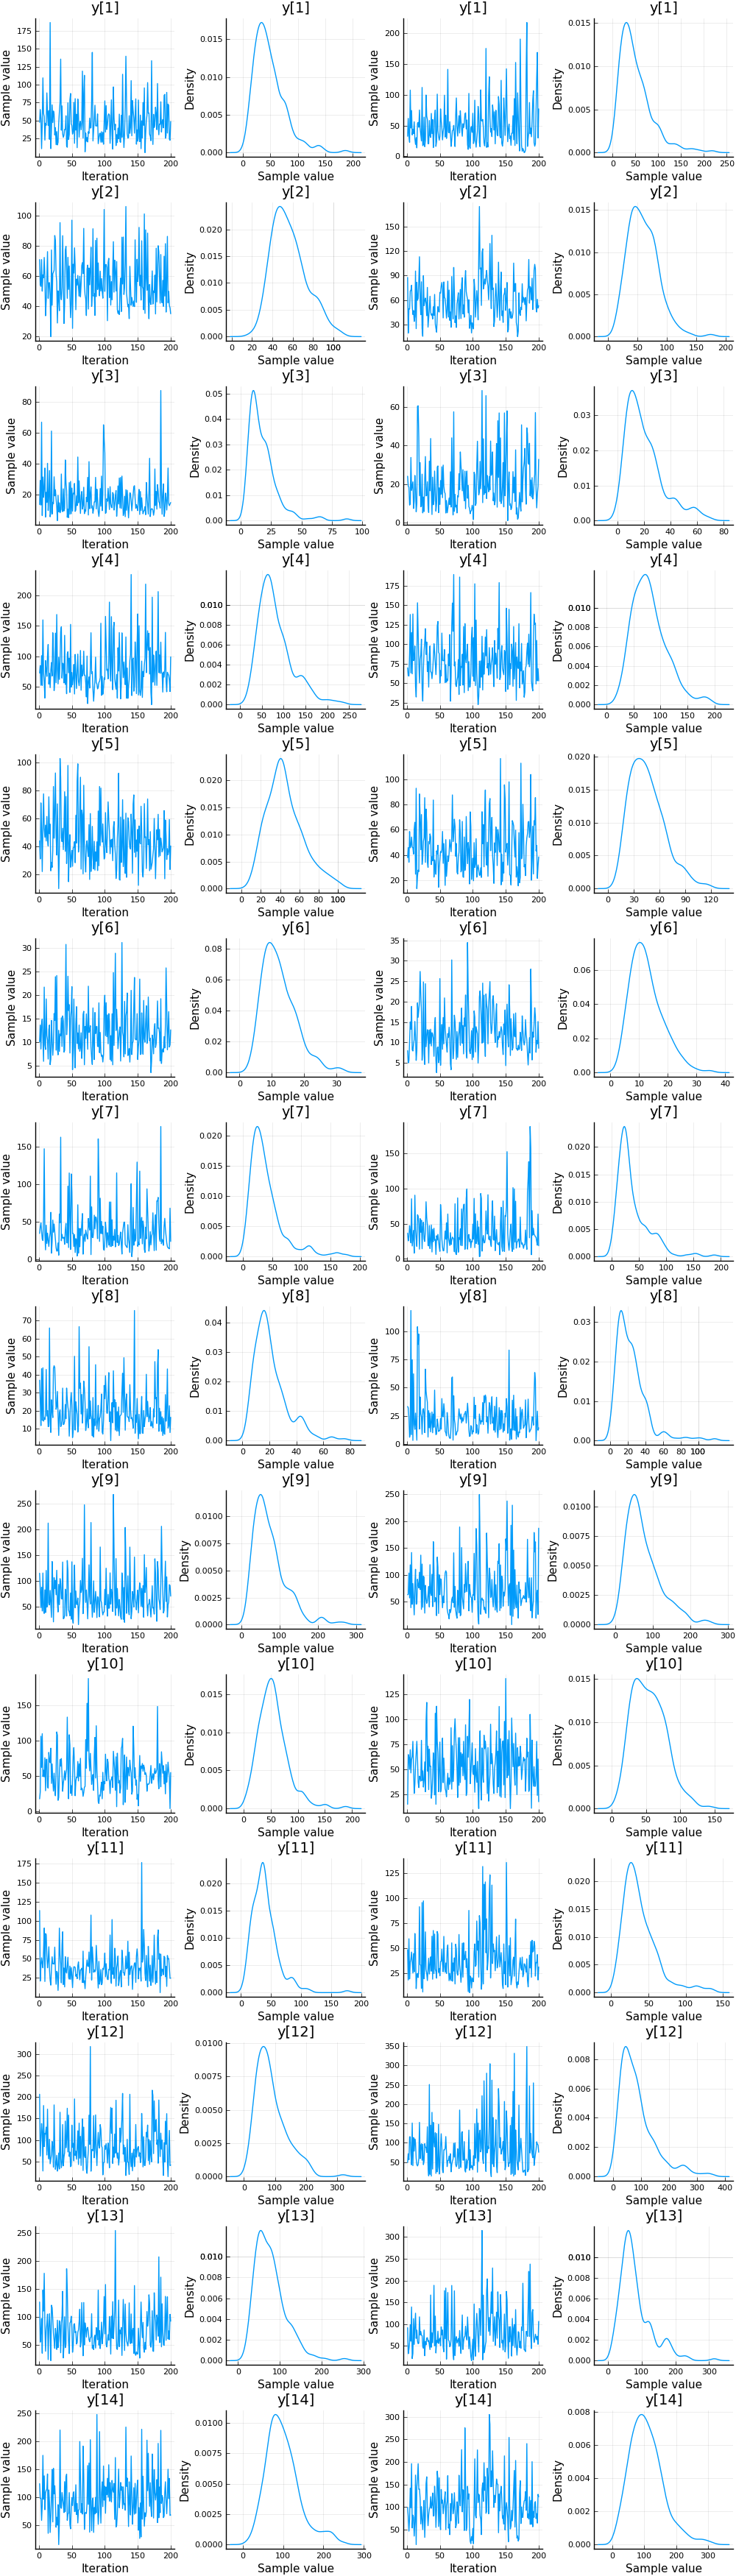

In [104]:
plot(p1, p2, layout = (1, 2))

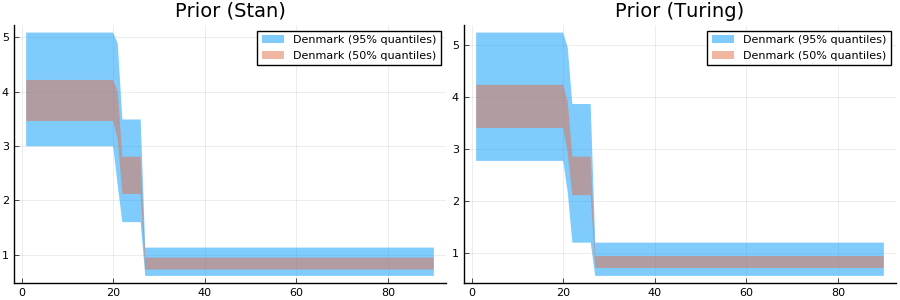

In [105]:
country_idx = 1

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

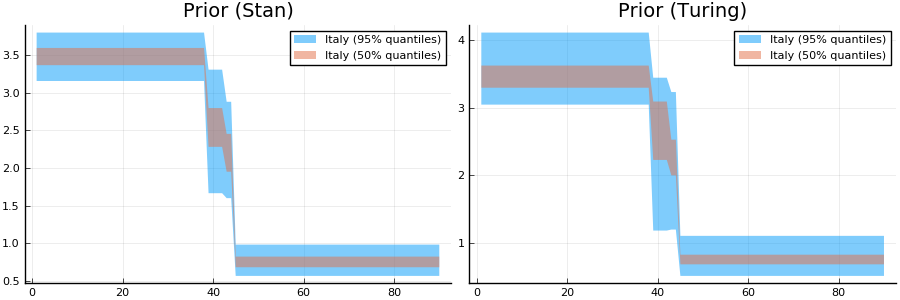

In [106]:
country_idx = 2

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

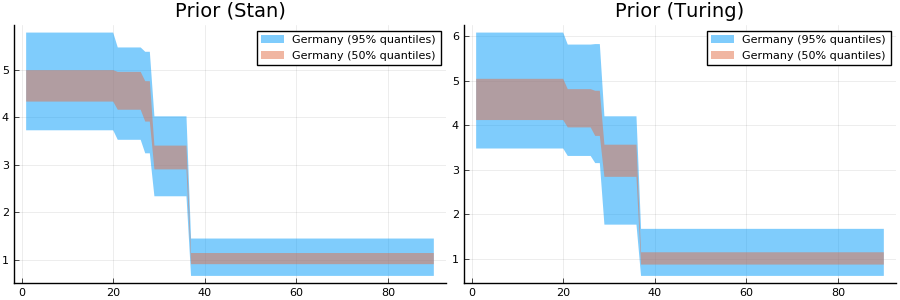

In [107]:
country_idx = 3

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

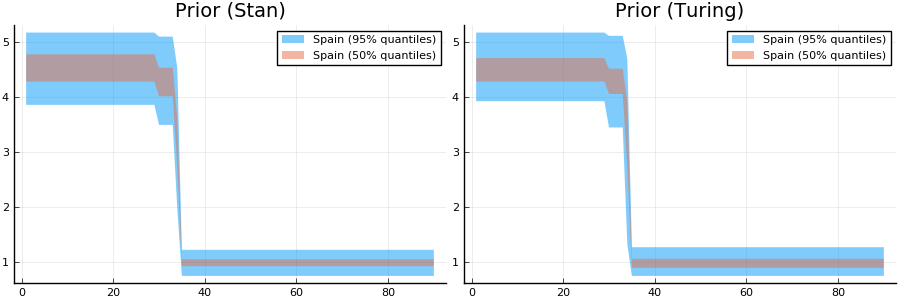

In [108]:
country_idx = 4

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

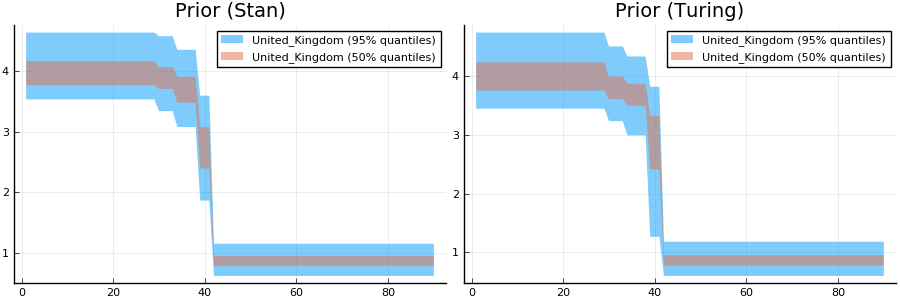

In [109]:
country_idx = 5

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

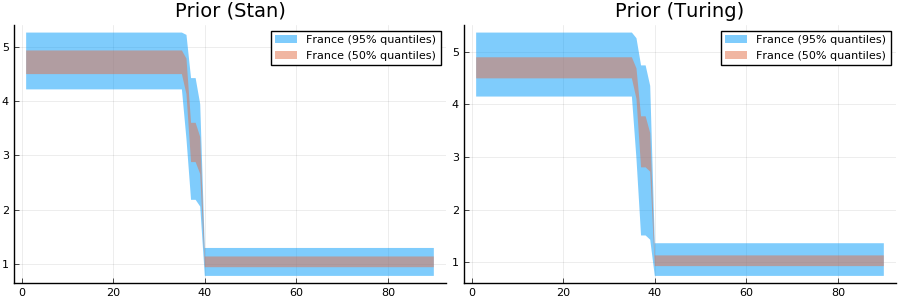

In [110]:
country_idx = 6

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

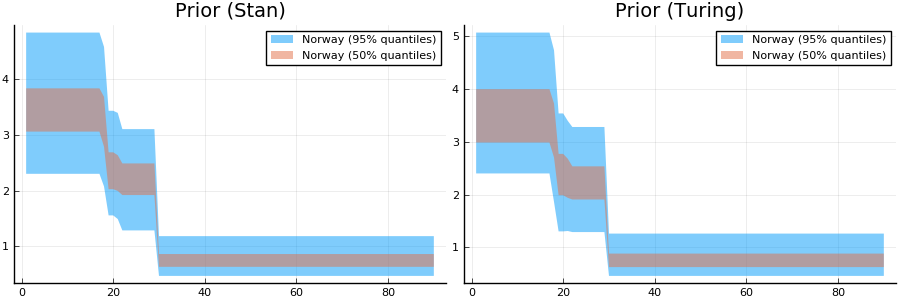

In [111]:
country_idx = 7

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

## Sampling from the prior

This approach to sampling from the prior using Stan comes from https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#step-four-build-a-model

In [59]:
stan_prior_model_str = """
data {
  int <lower=1> M; // number of countries
  int <lower=1> N0; // number of days for which to impute infections
  int<lower=1> N[M]; // days of observed data for country m. each entry must be <= N2
  int<lower=1> N2; // days of observed data + # of days to forecast
  int cases[N2,M]; // reported cases
  int deaths[N2, M]; // reported deaths -- the rows with i > N contain -1 and should be ignored
  matrix[N2, M] f; // h * s
  matrix[N2, M] covariate1;
  matrix[N2, M] covariate2;
  matrix[N2, M] covariate3;
  matrix[N2, M] covariate4;
  matrix[N2, M] covariate5;
  matrix[N2, M] covariate6;
  int EpidemicStart[M];
  real pop[M];
  real SI[N2]; // fixed pre-calculated SI using emprical data from Neil
}

generated quantities {
  real<lower=0> mu[M]; // intercept for Rt
  real<lower=0> alpha_hier[6]; // sudo parameter for the hier term for alpha
  real<lower=0> kappa;
  real<lower=0> y[M];
  real<lower=0> phi;
  real<lower=0> tau;
  real<lower=0> ifr_noise[M];

  real alpha[6];
  matrix[N2, M] prediction = rep_matrix(0,N2,M);
  matrix[N2, M] E_deaths  = rep_matrix(0,N2,M);
  matrix[N2, M] Rt = rep_matrix(0,N2,M);
  matrix[N2, M] Rt_adj = Rt;

  matrix[N2, M] prediction0 = rep_matrix(0,N2,M);
  matrix[N2, M] E_deaths0  = rep_matrix(0,N2,M);

  tau = exponential_rng(0.03);
  for (m in 1:M){
    y[m] = exponential_rng(1/tau);
  }
  phi = fabs(normal_rng(0,5));
  kappa = fabs(normal_rng(0,0.5));
  for (m in 1:M) mu[m] = fabs(normal_rng(3.28, kappa)); // citation: https://academic.oup.com/jtm/article/27/2/taaa021/5735319
  for (i in 1:6) alpha_hier[i] = gamma_rng(.1667,1);
  for (m in 1:M) ifr_noise[m] = fabs(normal_rng(1,0.1));
    
  {
    matrix[N2,M] cumm_sum = rep_matrix(0,N2,M);
    for(i in 1:6){
      alpha[i] = alpha_hier[i] - ( log(1.05) / 6.0 );
    }
    for (m in 1:M){
      for (i in 2:N0){
        cumm_sum[i,m] = cumm_sum[i-1,m] + y[m]; 
      }
      prediction[1:N0,m] = rep_vector(y[m],N0); // learn the number of cases in the first N0 days
        
      Rt[,m] = mu[m] * exp( covariate1[,m] * (-alpha[1]) + covariate2[,m] * (-alpha[2]) +
                            covariate3[,m] * (-alpha[3]) + covariate4[,m] * (-alpha[4]) + covariate5[,m] * (-alpha[5]) + 
                            covariate6[,m] * (-alpha[6]) );
      Rt_adj[1:N0,m] = Rt[1:N0,m];
      for (i in (N0+1):N2) {
        real convolution=0;
        for(j in 1:(i-1)) {
          convolution += prediction[j, m] * SI[i-j];
        }
        cumm_sum[i,m] = cumm_sum[i-1,m] + prediction[i-1,m];
        Rt_adj[i,m] = ((pop[m]-cumm_sum[i,m]) / pop[m]) * Rt[i,m];
        prediction[i, m] = Rt_adj[i,m] * convolution;
      }
        
      E_deaths[1, m]= 1e-15 * prediction[1,m];
      for (i in 2:N2){
        for(j in 1:(i-1)){
          E_deaths[i,m] += prediction[j,m] * f[i-j,m] * ifr_noise[m];
        }
      }
    }
  }

  {
    matrix[N2,M] cumm_sum0 = rep_matrix(0,N2,M);
    for (m in 1:M){
      for (i in 2:N0){
        cumm_sum0[i,m] = cumm_sum0[i-1,m] + y[m]; 
      }
      prediction0[1:N0,m] = rep_vector(y[m],N0); 
      for (i in (N0+1):N2) {
        real convolution0 = 0;
        for(j in 1:(i-1)) {
          convolution0 += prediction0[j, m] * SI[i-j]; 
        }
        cumm_sum0[i,m] = cumm_sum0[i-1,m] + prediction0[i-1,m];
        prediction0[i, m] =  ((pop[m]-cumm_sum0[i,m]) / pop[m]) * mu[m] * convolution0;
      }
        
      E_deaths0[1, m] = uniform_rng(1e-16, 1e-15);
      for (i in 2:N2){
        for(j in 1:(i-1)){
          E_deaths0[i,m] += prediction0[j,m] * f[i-j,m] * ifr_noise[m];
        }
      }
    }
  }
}

""";

In [60]:
sm_prior = pystan.StanModel(model_code=stan_prior_model_str)

fit_stan_prior(n_iters=2_000) = sm_prior.sampling(
    # I believe `refresh` ensures that we 
    data=d, iter=n_iters, chains=1, warmup=0, algorithm="Fixed_param", refresh=n_iters
)

f_prior = fit_stan_prior(10000)

Iteration:    1 / 10000 [  0%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               74.8134 seconds (Sampling)
               74.8134 seconds (Total)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f81a2e31bcfa3936009652c0191c457 NOW.


PyObject 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_8f81a2e31bcfa3936009652c0191c457.
1 chains, each with iter=10000; warmup=0; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                   mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
mu[1]              3.28  5.4e-3   0.51    2.16     3.1    3.28   3.46   4.38   9047    1.0
mu[2]              3.27  5.1e-3   0.51    2.13    3.09    3.28   3.46   4.36  10149    1.0
mu[3]              3.27  5.0e-3   0.51    2.15    3.09    3.28   3.46   4.38  10151    1.0
mu[4]              3.27  5.2e-3   0.51    2.11     3.1    3.28   3.46   4.38   9589    1.0
mu[5]              3.29  4.9e-3    0.5     2.2     3.1    3.28   3.47    4.4  10473    1.0
mu[6]              3.27  5.1e-3    0.5    2.15    3.09    3.28   3.46   4.36   9832    1.0
mu[7]              3.28  5.2e-3   0.51     2.2    3.09    3.28   3.46   4.43   9448    1.0
mu[8]              3.28  5.0e-3   

In [61]:
la_prior = f_prior.extract(permuted=true)

Dict{Any,Any} with 15 entries:
  "E_deaths"    => [1.93159e-14 2.94219e-7 … 1008.33 1043.77; 8.37835e-14 1.295…
  "ifr_noise"   => [0.932645 1.06777 … 0.941498 1.01813; 0.946476 0.991688 … 1.…
  "tau"         => [16.2041, 42.9077, 153.11, 23.2202, 74.2451, 25.5254, 3.2966…
  "Rt_adj"      => [3.78084 3.78084 … 0.585558 0.560035; 3.41405 3.41405 … 0.55…
  "mu"          => [3.78084 4.57955 … 4.41693 3.11725; 3.41405 3.09974 … 3.4714…
  "kappa"       => [1.03965, 0.341771, 0.026509, 0.691418, 0.0179919, 0.503431,…
  "phi"         => [3.65083, 0.920548, 1.78998, 0.637701, 2.73622, 6.42802, 2.1…
  "prediction"  => [19.3159 19.3159 … 69786.9 63050.7; 83.7835 83.7835 … 46193.…
  "alpha_hier"  => [3.49166e-5 0.0761509 … 0.196094 0.118679; 0.000500638 9.942…
  "Rt"          => [3.78084 3.78084 … 2.1183 2.1183; 3.41405 3.41405 … 1.97992 …
  "y"           => [19.3159 2.39715 … 21.9235 4.43297; 83.7835 19.0364 … 40.310…
  "alpha"       => [-0.00809678 0.0680193 … 0.187963 0.110548; -0.00763106 -0.

In [112]:
mean_Rₜ_stan = mean(la_prior["Rt"]; dims = 1)[1, :, :]

90×14 Array{Float64,2}:
 3.28131  3.27195  3.26944  3.27196  …  3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196  …  3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196  …  3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 

In [113]:
res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

In [114]:
mean_Rₜ_turing = mean([hcat(Rₜ_prior[i]...) for i = 1:length(Rₜ_prior)])

90×14 Array{Float64,2}:
 3.28235  3.28181  3.27853  3.28602  …  3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602  …  3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602  …  3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 

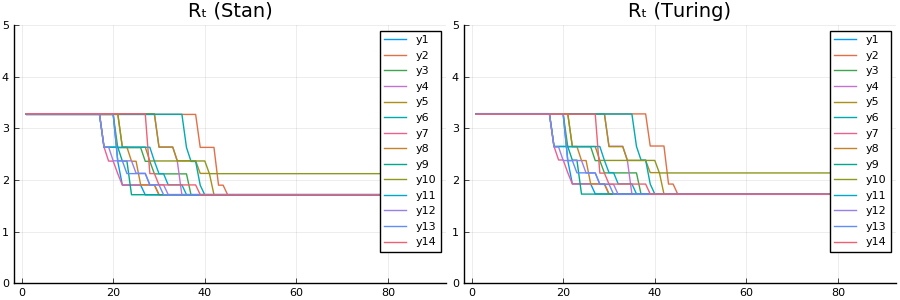

In [115]:
p1 = plot(mean_Rₜ_stan)
title!("Rₜ (Stan)")

p2 = plot(mean_Rₜ_turing)
title!("Rₜ (Turing)")

plot(p1, p2, size = (900, 300))
ylims!(0, 5)

In [116]:
stan_prior_chain = Chains(la_prior["y"], ["y[$i]" for i = 1:size(la_prior["y"], 2)])

Object of type Chains, with data of type 10000×14×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean      std  naive_se    mcse         ess   r_hat
  ──────────  ───────  ───────  ────────  ──────  ──────────  ──────
        y[1]  34.1684  60.3428    0.6034  0.5971  10231.2254  1.0000
        y[2]  33.3878  57.1536    0.5715  0.5940  10345.6889  1.0002
        y[3]  33.6822  58.6989    0.5870  0.6520   8930.0235  1.0001
        y[4]  33.2693  57.9423    0.5794  0.5481   9930.0544  0.9999
        y[5]  33.9689  61.9302    0.6193  0.6284   9507.2542  1.0001
        y[6]  34.2339  60.0826    0.6008  0.5547  10032.3907  1.0000
        y[7]  35.3289  65.2461    0.6525  0.6251   9835.0885  0.9999
        y[8]  34.3868  60.0357    0.6004  0.5239

In [117]:
p1 = plot(stan_prior_chain[:y]);

In [118]:
p2 = plot(chain_prior[:y]);

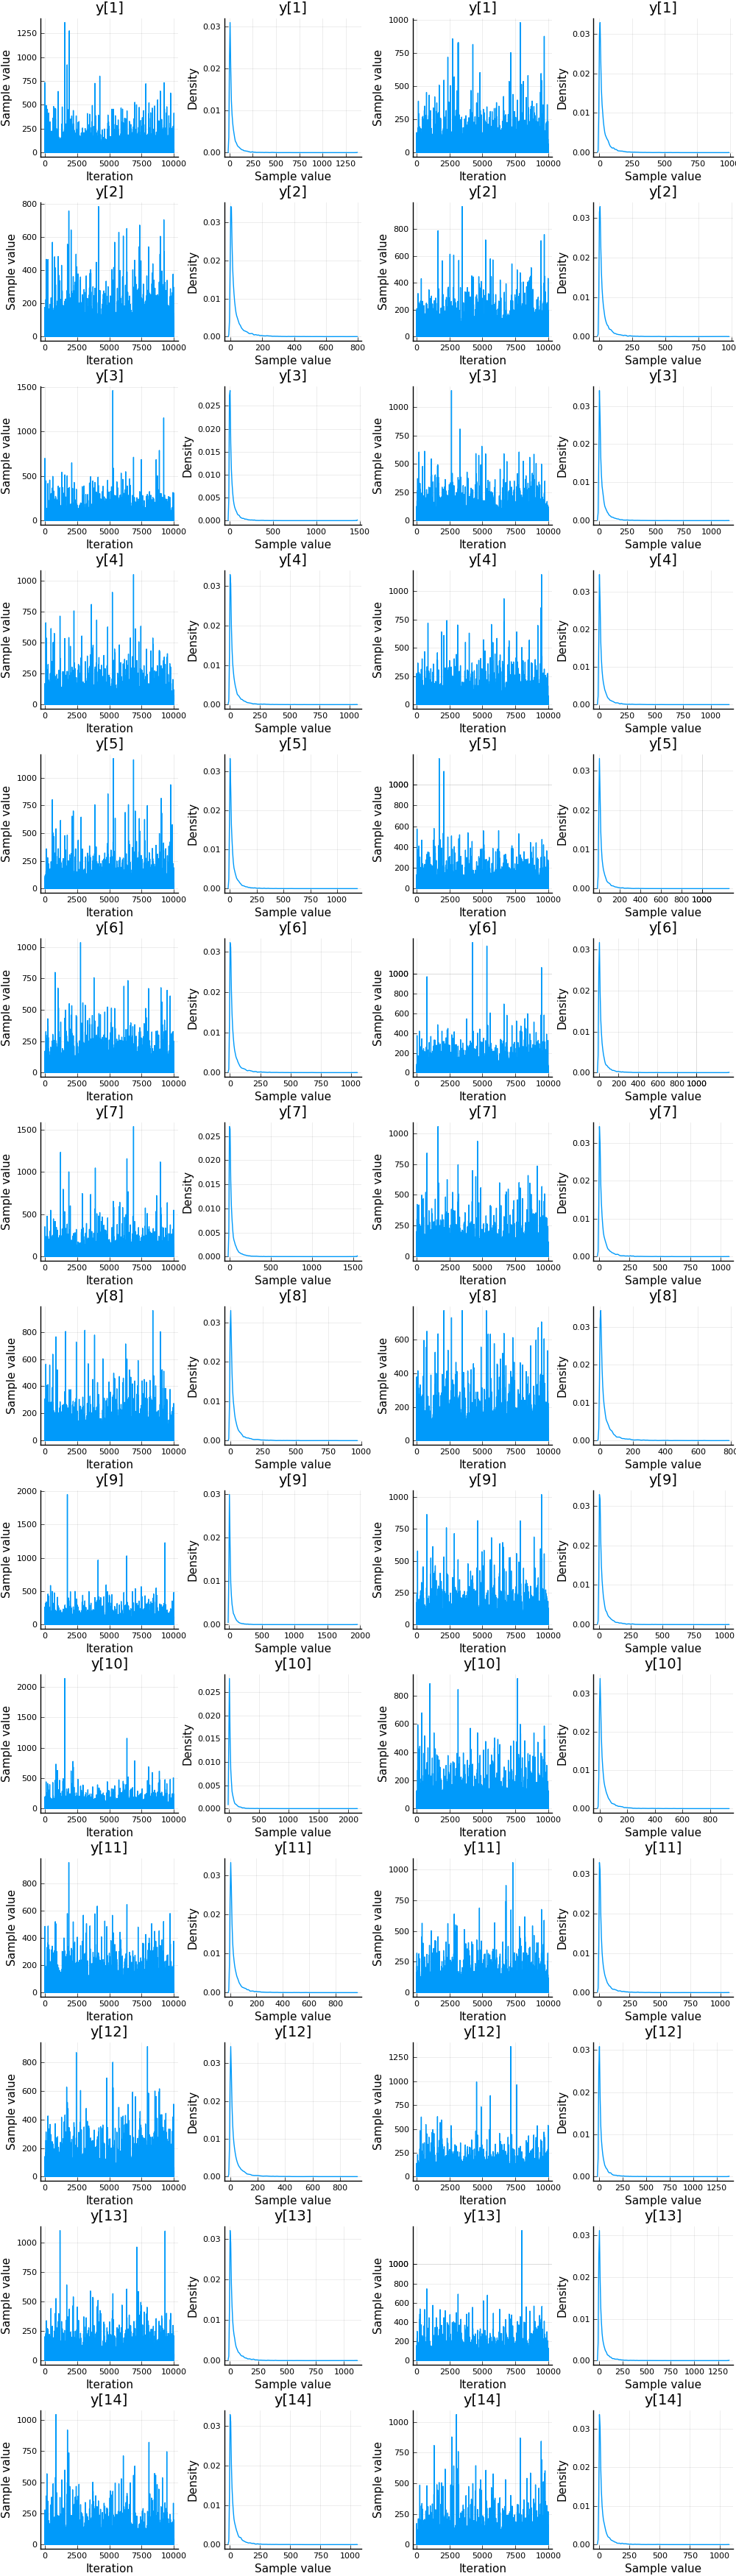

In [119]:
plot(p1, p2, layout = (1, 2))

In [120]:
country_idx = 7

7

In [121]:
hcat([Rₜ_prior[i][country_idx] for i = 1:10_000]...)'

10000×90 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 3.29968  3.29968  3.29968  3.29968  3.29968  …  2.33792   2.33792   2.33792 
 3.61216  3.61216  3.61216  3.61216  3.61216     3.42996   3.42996   3.42996 
 3.33432  3.33432  3.33432  3.33432  3.33432     1.94388   1.94388   1.94388 
 3.45655  3.45655  3.45655  3.45655  3.45655     2.3189    2.3189    2.3189  
 3.27459  3.27459  3.27459  3.27459  3.27459     0.774836  0.774836  0.774836
 3.33379  3.33379  3.33379  3.33379  3.33379  …  1.17719   1.17719   1.17719 
 3.72393  3.72393  3.72393  3.72393  3.72393     3.38807   3.38807   3.38807 
 2.72857  2.72857  2.72857  2.72857  2.72857     0.178619  0.178619  0.178619
 3.04221  3.04221  3.04221  3.04221  3.04221     1.17235   1.17235   1.17235 
 3.79909  3.79909  3.79909  3.79909  3.79909     1.12903   1.12903   1.12903 
 2.88363  2.88363  2.88363  2.88363  2.88363  …  1.28103   1.28103   1.28103 
 3.24855  3.24855  3.24855  3.24855  3.24855     2.93994   2.93994   2.93994 
 3.208

In [122]:
la_prior["Rt"][:, :, country_idx]

10000×90 Array{Float64,2}:
 3.534    3.534    3.534    3.534    …  1.98001    1.98001    1.98001  
 2.73274  2.73274  2.73274  2.73274     1.58481    1.58481    1.58481  
 3.28135  3.28135  3.28135  3.28135     2.90651    2.90651    2.90651  
 3.89443  3.89443  3.89443  3.89443     1.93188    1.93188    1.93188  
 3.28516  3.28516  3.28516  3.28516     2.3406     2.3406     2.3406   
 2.91645  2.91645  2.91645  2.91645  …  1.37546    1.37546    1.37546  
 3.27458  3.27458  3.27458  3.27458     3.22629    3.22629    3.22629  
 3.08715  3.08715  3.08715  3.08715     0.351149   0.351149   0.351149 
 3.87312  3.87312  3.87312  3.87312     3.37153    3.37153    3.37153  
 2.45081  2.45081  2.45081  2.45081     2.53       2.53       2.53     
 3.04146  3.04146  3.04146  3.04146  …  0.714928   0.714928   0.714928 
 4.29187  4.29187  4.29187  4.29187     0.0825957  0.0825957  0.0825957
 3.41862  3.41862  3.41862  3.41862     0.985535   0.985535   0.985535 
 ⋮                                   

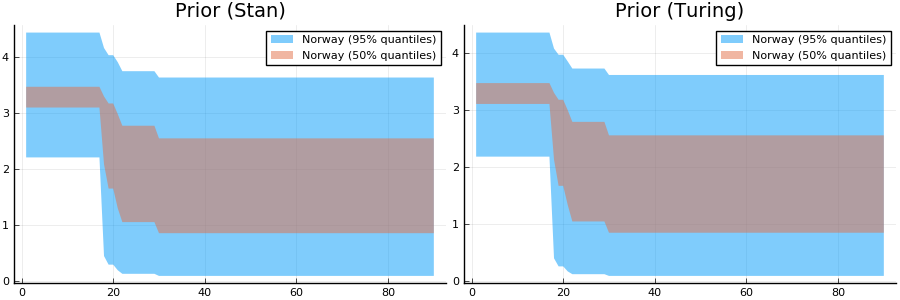

In [123]:
vals = la_prior["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_prior[i][country_idx] for i = 1:10_000]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

In [124]:
stan_chain_alpha_hier = Chains(la_prior["alpha_hier"], ["α_hier[$i]" for i = 1:6])

Object of type Chains, with data of type 10000×6×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse         ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ──────────  ──────
   α_hier[1]  0.1673  0.4020    0.0040  0.0037   9534.1084  1.0003
   α_hier[2]  0.1692  0.4160    0.0042  0.0044  10113.1276  1.0001
   α_hier[3]  0.1687  0.4110    0.0041  0.0039  10211.8029  1.0000
   α_hier[4]  0.1708  0.4190    0.0042  0.0044  10161.5811  1.0000
   α_hier[5]  0.1629  0.4172    0.0042  0.0048  10077.0580  0.9999
   α_hier[6]  0.1660  0.4140    0.0041  0.0042   9751.3710  1.0000

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
   α_hier[1]  0.0000  0.0002  0.0096  0.

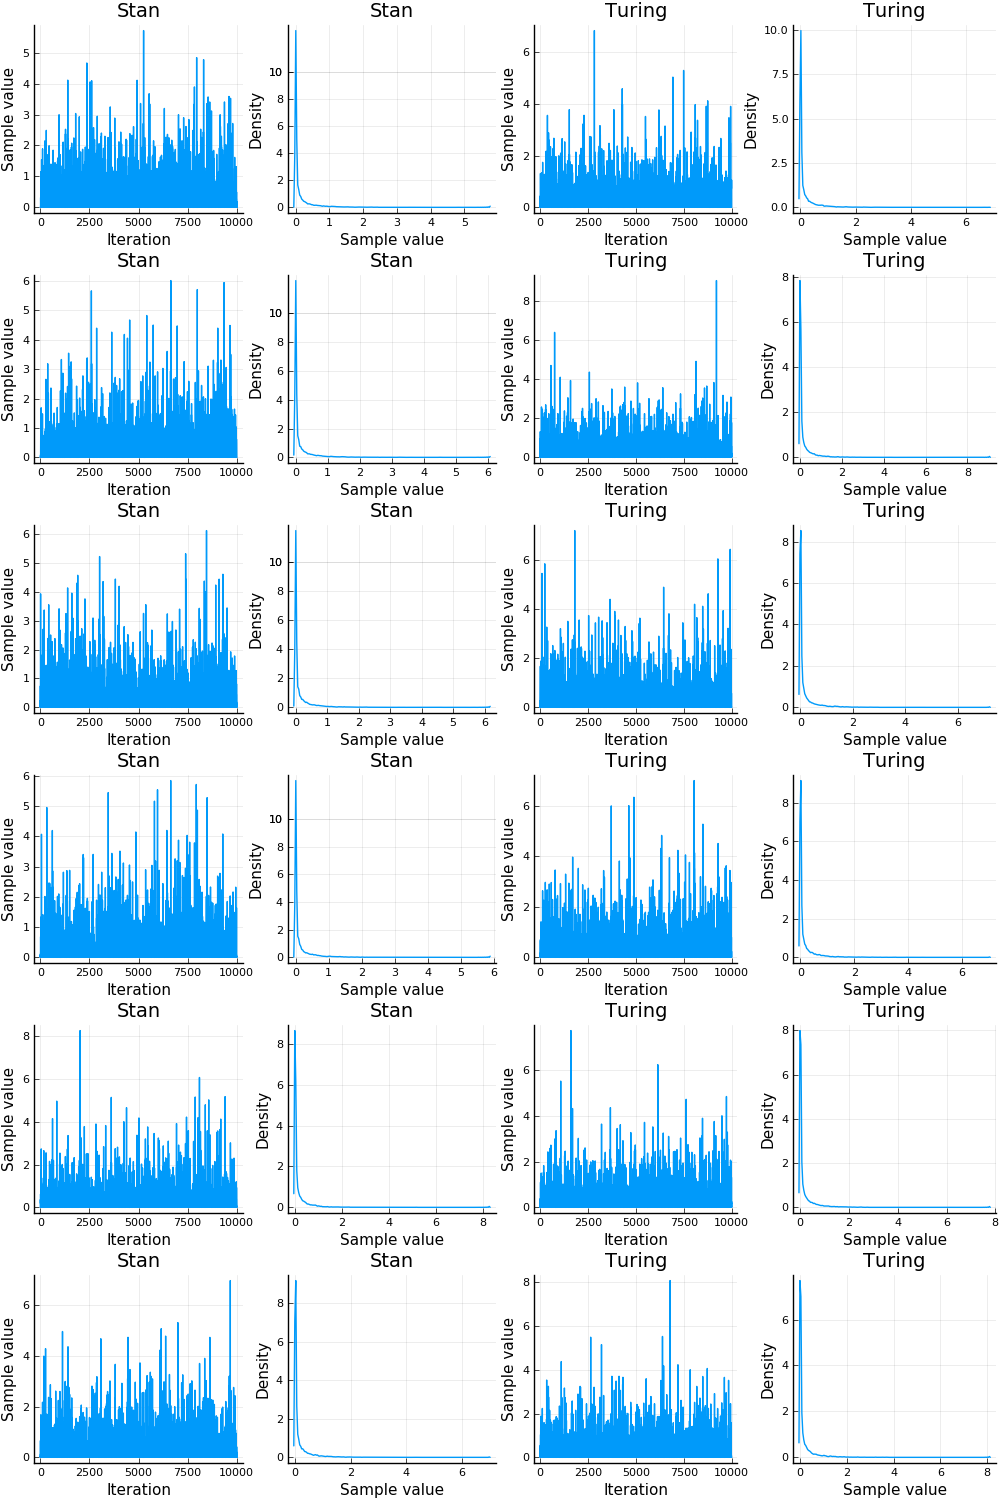

In [125]:
p1 = plot(stan_chain_alpha_hier[:α_hier])
title!("Stan")
p2 = plot(chain_prior[:α_hier])
title!("Turing")

plot(p1, p2, layout = (1, 2))